In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [2]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
#d = b2wCorpus.index[b2wCorpus["overall_rating"] == 2].tolist()
#b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
#b2wCorpus['overall_rating'].replace({5: 2}, inplace = True)
#print(b2wCorpus.head)

In [3]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [4]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [5]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [6]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [7]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    1   produto ruim material ruim parece guardanapo pia
1                    1           hoje chegou sapato veio cinto devo fazer
2                    3  produto bom cola nao fixa direito azulejo crem...
3                    1  nao deveriam deixa coloca anuncio desses porte...
4                    5  bom produto top demais bom atendimento entrega...
...                ...                                                ...
132368               1  gente hoje faz exatamente dias ainda nao receb...
132369               3  pra precisa smartphone preco acessivel boa esc...
132370               5  excelente tritura tudo rapido lindo entrega su...
132371               3  bonita confortavel crianca so gente coloca cri...
132372               1             nao recebi produto ainda posso avaliar

[132373 rows x 2 columns]>


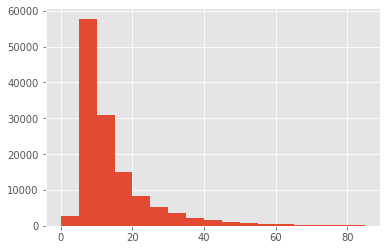

131993


In [8]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=100 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
plt.show()
print(len(Words))

In [9]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '199999'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [10]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [11]:
b2wCorpus.shape

(132373, 3)

In [12]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 30].index)

In [13]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [14]:
b2wCorpus.shape

(60652, 3)

In [15]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [16]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,2,"[902, 226, 12568, 7804, 3033, 228, 31755, 1162...",18
1,0,"[7804, 2430, 1209, 3311, 37020, 1172, 4328, 15...",11
2,3,"[49433, 363, 21061, 49433, 4068, 150061, 218, ...",11
3,0,"[902, 7305, 173, 7804, 320, 5301, 199999, 4006...",18
4,3,"[2499, 85324, 168, 902, 5464, 199999, 12783, 9...",13


In [17]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [18]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=30, padding='post').tolist()

In [19]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,2,"[902, 226, 12568, 7804, 3033, 228, 31755, 1162...",18
1,0,"[7804, 2430, 1209, 3311, 37020, 1172, 4328, 15...",11
2,3,"[49433, 363, 21061, 49433, 4068, 150061, 218, ...",11
3,0,"[902, 7305, 173, 7804, 320, 5301, 199999, 4006...",18
4,3,"[2499, 85324, 168, 902, 5464, 199999, 12783, 9...",13


In [20]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [22]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
32557,3,"[4207, 1815, 763, 5144, 18122, 4792, 10883, 19...",30
27270,0,"[2832, 406, 7804, 7256, 72644, 11882, 39, 321,...",30
609,2,"[902, 226, 1602, 25764, 26012, 2789, 61637, 77...",30
55093,3,"[3143, 11735, 2499, 5437, 85324, 15480, 902, 3...",30
40284,1,"[363, 303, 1129, 111326, 1851, 1390, 3555, 199...",30


In [23]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
11369               2  [199999, 1664, 902, 1083, 4680, 194, 199999, 7...   30
29954               1  [9735, 20206, 79, 1681, 199999, 149705, 231, 2...   30
43149               0  [16130, 101071, 902, 3822, 250, 1623, 89314, 1...   30
28830               1  [2470, 404, 226, 407, 323, 199999, 201, 3331, ...   30
13850               0  [231, 1316, 199999, 9735, 902, 12783, 18874, 2...   30
...               ...                                                ...  ...
28658               3  [363, 702, 22522, 902, 88, 5566, 39, 63936, 86...   10
55064               3  [63936, 428, 566, 321, 3690, 73, 39, 1249, 167...   10
18072               2  [7804, 6376, 2499, 5460, 733, 199999, 53, 1897...   10
51524               0  [13241, 1027, 5135, 1100, 106791, 5437, 652, 2...   10
37830               4  [226, 84241, 420, 7538, 2951, 7498, 5427, 1010...   10

[6065 rows x 3 columns]>

In [24]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
30844               3  [101071, 1602, 25764, 148934, 93, 428, 173, 19...   30
36047               1  [23904, 6217, 34717, 30029, 7804, 6455, 4402, ...   30
20666               3  [1336, 101, 62, 112, 199999, 363, 2694, 63936,...   30
7415                0  [9735, 516, 1850, 3281, 5841, 115801, 1664, 62...   30
32482               1  [4644, 2989, 643, 958, 125, 1229, 7256, 14548,...   30
...               ...                                                ...  ...
59048               3  [6376, 183709, 199999, 21770, 553, 4758, 30941...   10
41800               3  [12423, 1844, 929, 30481, 467, 87763, 23941, 4...   10
4938                3  [362, 2499, 297, 2999, 268, 964, 199999, 767, ...   10
39939               2  [6376, 902, 101071, 532, 5841, 2697, 6851, 935...   10
52888               2  [532, 1188, 44640, 199999, 70, 153, 201, 11044...   10

[15164 rows x 3 columns]>

In [25]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [26]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()
#emb.trainable = True

In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 30
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(keras.layers.LSTM(128, dropout=0.5))
#model.add(Dropout(0.50))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
2464/2464 [==============================] - 38s 15ms/step - loss: 1.2976 - accuracy: 0.4706 - val_loss: 1.1598 - val_accuracy: 0.5235
Epoch 2/50
2464/2464 [==============================] - 37s 15ms/step - loss: 1.1944 - accuracy: 0.5100 - val_loss: 1.0991 - val_accuracy: 0.5439
Epoch 3/50
2464/2464 [==============================] - 38s 15ms/step - loss: 1.1463 - accuracy: 0.5288 - val_loss: 1.0685 - val_accuracy: 0.5482
Epoch 4/50
2464/2464 [==============================] - 38s 16ms/step - loss: 1.1157 - accuracy: 0.5396 - val_loss: 1.0391 - val_accuracy: 0.5674
Epoch 5/50
2464/2464 [==============================] - 38s 15ms/step - loss: 1.0950 - accuracy: 0.5478 - val_loss: 1.0325 - val_accuracy: 0.5756
Epoch 6/50
2464/2464 [==============================] - 38s 16ms/step - loss: 1.0801 - accuracy: 0.5535 - val_loss: 1.0047 - val_accuracy: 0.5855
Epoch 7/50
2464/2464 [==============================] - 38s 15ms/step - loss: 1.0632 - accuracy: 0.5588 - val_loss: 1.0061 -

In [ ]:
print(opt)

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();